In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data_utils

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from pathlib import Path
import zipfile

In [3]:
CLEAN_IMGS = True  # clean extracted images at the end, to prevent overcrowding the output console
CAT, DOG = 0, 1
def lbl_code_to_class(label):
    return 'dog' if label == DOG else 'cat'

def class_to_lbl_code(class_name):
    return CAT if class_name == 'cat' else DOG

In [4]:
# Use GPU if available

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}')

Running on cuda


# Load the dataset

In [5]:
# Extract and load data

DATA_DIR = Path('/kaggle/working/data')

if not all ([os.path.exists(DATA_DIR / directory) for directory in ['train', 'test']]):
    print('Extracting data...')
    if not os.path.exists(DATA_DIR / 'train'):
        with zipfile.ZipFile("/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip", 'r') as z:
            z.extractall(DATA_DIR)
    if not os.path.exists(DATA_DIR / 'test'):
        with zipfile.ZipFile("/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip", 'r') as z:
            z.extractall(DATA_DIR)
    print('Done')

print([str(DATA_DIR / directory) for directory in os.listdir(DATA_DIR)])
# the zip files are extracted to new folders 'train' & 'test'
TRAINING_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'

training_set_full_raw = [TRAINING_DIR / filename for filename in os.listdir(TRAINING_DIR) if filename.endswith('.jpg')]
test_set_raw = [TEST_DIR / filename for filename in os.listdir(TEST_DIR) if filename.endswith('.jpg')]

Extracting data...
Done
['/kaggle/working/data/test', '/kaggle/working/data/train']


## Peek at the data

Training data: 25000, Sample: /kaggle/working/data/train/cat.4040.jpg
Test data: 12500, Sample: /kaggle/working/data/test/8125.jpg


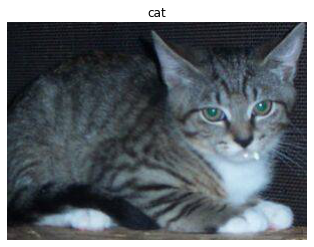

In [6]:
SAMPLE_IMG_ID = np.random.choice(min(len(test_set_raw), len(training_set_full_raw)))

print(f'Training data: {len(training_set_full_raw)}, Sample: {training_set_full_raw[SAMPLE_IMG_ID]}')
print(f'Test data: {len(test_set_raw)}, Sample: {test_set_raw[SAMPLE_IMG_ID]}')

sample_img, sample_img_label = Image.open(training_set_full_raw[SAMPLE_IMG_ID]), training_set_full_raw[SAMPLE_IMG_ID].name.split('.')[0]
plt.axis(False)
junk = plt.imshow(sample_img)
junk = plt.title(sample_img_label)

## Count and organize data

In [7]:
from collections import defaultdict


training_full_classes = defaultdict(int)

for path in training_set_full_raw:
    training_full_classes[path.name.split('.')[0]] += 1

print(f'Classes: {[(k,v) for k,v in training_full_classes.items()]}')

NUM_CLASSES = len(training_full_classes.keys())

# => 12500 / 12500 , data already balanced

Classes: [('dog', 12500), ('cat', 12500)]


## Convert to pytorch Dataset

In [8]:
class CustomDataset(Dataset):
    def __init__(self, data, train=False, transformer=None):
        self.data = data
        self.train = train
        self.transformer = transformer
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        if self.transformer:
            img = self.transformer(img)
            
        lbl = self.data[idx].name.split('.')[0]
        lbl = class_to_lbl_code(lbl) if self.train else int(lbl)
        return img.numpy().astype('float32'), lbl

data_transformer = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet parameters
])

np.random.shuffle(training_set_full_raw)
training_set_full = CustomDataset(training_set_full_raw, train=True, transformer=data_transformer)
test_set = CustomDataset(test_set_raw, train=False, transformer=data_transformer)

IMAGE_SHAPE = training_set_full[0][0].shape
print(f'Image shape: {IMAGE_SHAPE}')

Image shape: (3, 224, 224)


## Split to train / validation / test

In [9]:
VALIDATION_FRAC = 0.1
BATCH_SIZE = 64

np.random.seed(42)
shuffled_idx = np.random.choice(len(training_set_full), len(training_set_full), replace=False)
validation_set = data_utils.Subset(training_set_full, shuffled_idx[:int(len(training_set_full) * 0.1)])
training_set = data_utils.Subset(training_set_full, shuffled_idx[int(len(training_set_full) * 0.1):])

print('Data size after splitting to train / validation / test:')
print(f'Training data: {len(training_set)}, Sample structure: ({type(training_set[0][0])} {training_set[0][0].shape}, {type(training_set[0][1])})')
print(f'Validation data: {len(validation_set)}, Sample structure: ({type(validation_set[0][0])} {validation_set[0][0].shape}, {type(validation_set[0][1])})')
print(f'Test data: {len(test_set)}, Sample structure: ({type(test_set[0][0])} {test_set[0][0].shape}, {type(test_set[0][1])})')

training_loader = DataLoader(dataset=training_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False)
validation_loader = DataLoader(dataset=validation_set, batch_size=BATCH_SIZE, shuffle=False)  # don't shuffle (!) to visualize results correctly.
                                                                                              # it's ok because we shuffled the original ds.

Data size after splitting to train / validation / test:
Training data: 22500, Sample structure: (<class 'numpy.ndarray'> (3, 224, 224), <class 'int'>)
Validation data: 2500, Sample structure: (<class 'numpy.ndarray'> (3, 224, 224), <class 'int'>)
Test data: 12500, Sample structure: (<class 'numpy.ndarray'> (3, 224, 224), <class 'int'>)


# Model

In [10]:
def calc_out_size(in_size, padding, kernel, stride):
    # formula from: https://youtu.be/wnK3uWv_WkU?t=234
    # assuming nxn
    padding = padding if isinstance(padding, int) else padding[0]
    kernel = kernel if isinstance(kernel, int) else kernel[0]
    stride = stride if isinstance(stride, int) else stride[0]
    return ((in_size + 2*padding - kernel) // stride) + 1


class CNN(nn.Module):
    def __init__(self, dimensions, in_channels, num_classes):
        super().__init__()
        self.dimensions = dimensions
        self.num_classes = num_classes
        self.current_size = 0
        
        # pooling
        self.pool = nn.MaxPool2d(kernel_size=3)
        
        # dropout
        self.dropout = nn.Dropout(0.5)
                
        # layer 1
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=(3,3)),)
#                                    nn.BatchNorm2d(32))  # Makes loss unstable!!
        self.update_size(self.conv1[0], dims=self.dimensions)
        self.update_size(self.pool)
        
        # layer 2
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=self.conv1[0].out_channels, out_channels=64, kernel_size=(3,3)),)
#                                    nn.BatchNorm2d(64))
        self.update_size(self.conv2[0])
        self.update_size(self.pool)
        
        # layer 3
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=self.conv2[0].out_channels, out_channels=128, kernel_size=(3,3)),)
#                                    nn.BatchNorm2d(128))
        self.update_size(self.conv3[0])
        self.update_size(self.pool)
        
        # layer 4
#         self.conv4 = nn.Sequential(nn.Conv2d(in_channels=self.conv3[0].out_channels, out_channels=256, kernel_size=(3,3)),)
# #                                    nn.BatchNorm2d(256))
#         self.update_size(self.conv4[0])
#         self.update_size(self.pool)
    
        # layer 5
        self.fc1 = nn.Linear(self.conv3[0].out_channels*self.current_size*self.current_size, 512)
        
        # layer 6
        self.fc2 = nn.Linear(512, self.num_classes)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
#         x = F.relu(self.conv4(x))
#         x = self.pool(x)
        
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        # TODO: softmax?
        
        return x
    
    def update_size(self, layer, dims=None):
        # assuming width == height
        self.current_size = calc_out_size(in_size=dims if dims else self.current_size, padding=layer.padding, kernel=layer.kernel_size, stride=layer.stride)
        print(f'self.current_size = {self.current_size}')

model = CNN(IMAGE_SHAPE[-1], IMAGE_SHAPE[0], NUM_CLASSES)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

self.current_size = 222
self.current_size = 74
self.current_size = 72
self.current_size = 24
self.current_size = 22
self.current_size = 7


In [11]:
model

CNN(
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  )
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [12]:
def evaluate(model, loss_function, X, y):
    predictions = model(X)
    
    loss = loss_function(predictions, y)
    predictions = predictions.argmax(dim=1).cpu().numpy()
    acc = (predictions == y.cpu().numpy()).mean()
    return predictions, acc, loss

## Training

In [13]:
EPOCHS = 7
EVALUATION_FREQ = len(training_set) // BATCH_SIZE // 10  # guarantee 10 evaluations per epoch
EARLY_STOPPING_K = 2  # consecutive non-increase to stop (None or 0 to not stop early)
EARLY_STOPPING_EPS = 0.01

model.train(mode=True)  # just puts the model in training mode (doesn't actually train)

training_acc_lst, training_loss_lst = [], []
validation_acc_lst, validation_loss_lst = [], []
not_increasing = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}')
    prev_epoch_acc, epoch_acc = 0, 0
    training_acc_checkpoint, training_loss_checkpoint = [], []
    for batch_idx, (data, labels) in enumerate(training_loader):
        # cast to device (cpu / gpu) (gpu for faster op). also both need to be on same device.
        data, labels = data.to(device), labels.to(device)
        
        # run model on data to get predictions.
        # data is of shape (BATCH_SIZE, 1, 224, 224),
        predictions, acc, loss = evaluate(model, loss_function, data, labels)
        training_acc_checkpoint.append(acc)

        # loss already calculated in the evaluate() call. just append it
        training_loss_checkpoint.append(loss.item())
        
        # back propagation (calculate the gradient)
        loss.backward()

        # gradient descent (adjust the weights)
        optimizer.step()

        # default behavior of pytorch is to NOT clear the gradients after every step.
        # but we need to clear them to prevent accumulation of gradients throughout iterations.
        optimizer.zero_grad()  # or model.zero_grad() if all the model's parameters are in the optimizer (in our case they are)

        # evaluate on validation
        if batch_idx % EVALUATION_FREQ == 0 or batch_idx == len(training_loader) - 1:
            # average training acc and loss every EVALUATION_FREQ, so our training and validation plots axes will have the same length
            training_acc_lst.append(np.mean(training_acc_checkpoint))
            training_loss_lst.append(np.mean(training_loss_checkpoint))
            # restart checkpoints
            training_acc_checkpoint, training_loss_checkpoint = [], []

            # predict validation data, but first disable gradient tracking, and enter evaluation mode
            model.train(mode=False)  # enter eval mode. suggested here: https://stackoverflow.com/a/55627781/900394
            with torch.no_grad():  # locally disable gradient tracking
                validation_acc_checkpoint, validation_loss_checkpoint = [], []
                validation_predictions = []  # saved for showing results later
                for val_batch_idx, (val_data, val_labels) in enumerate(validation_loader):
                    val_data, val_labels = val_data.to(device), val_labels.to(device)

                    val_predictions, validation_acc, validation_loss = evaluate(model, loss_function, val_data, val_labels)
                    
                    validation_loss_checkpoint.append(validation_loss.item())
                    validation_acc_checkpoint.append(validation_acc)
                    validation_predictions.extend(val_predictions)  # predictions are for a complete batch, so we need to "extend" not "append"
                
                validation_acc_lst.append(np.mean(validation_acc_checkpoint))
                validation_loss_lst.append(np.mean(validation_loss_checkpoint))
                
                if batch_idx == len(training_loader) - 1:
                    prev_epoch_acc = epoch_acc
                    epoch_acc = validation_acc_lst[-1]
            
            print(f'Training acc: {training_acc_lst[-1]:.2f}, Training loss: {training_loss_lst[-1]:.2f}, Validation acc: {validation_acc_lst[-1]:.2f}, Validation loss: {validation_loss_lst[-1]:.2f}')

            model.train(mode=True)  # re-enter training mode

    # epoch end
    
    # early stopping according to validation accuracy
    increase = epoch_acc - prev_epoch_acc
    not_increasing = (not_increasing + 1) if increase < EARLY_STOPPING_EPS else 0
    if EARLY_STOPPING_K and not_increasing >= EARLY_STOPPING_K:
        print(f'Less than {EARLY_STOPPING_EPS} accuracy increase in the last {not_increasing} consecutive epochs. Early stopping...')
        break

print('\nDone training.')

junk = model.train(mode=False)  # exit training mode

Epoch 1
Training acc: 0.58, Training loss: 0.69, Validation acc: 0.49, Validation loss: 0.71
Training acc: 0.51, Training loss: 0.69, Validation acc: 0.51, Validation loss: 0.69
Training acc: 0.53, Training loss: 0.69, Validation acc: 0.55, Validation loss: 0.68
Training acc: 0.59, Training loss: 0.67, Validation acc: 0.62, Validation loss: 0.65
Training acc: 0.65, Training loss: 0.64, Validation acc: 0.58, Validation loss: 0.69
Training acc: 0.64, Training loss: 0.64, Validation acc: 0.67, Validation loss: 0.62
Training acc: 0.68, Training loss: 0.61, Validation acc: 0.70, Validation loss: 0.59
Training acc: 0.67, Training loss: 0.62, Validation acc: 0.69, Validation loss: 0.60
Training acc: 0.70, Training loss: 0.58, Validation acc: 0.63, Validation loss: 0.67
Training acc: 0.70, Training loss: 0.57, Validation acc: 0.73, Validation loss: 0.54
Training acc: 0.72, Training loss: 0.56, Validation acc: 0.76, Validation loss: 0.51
Training acc: 0.89, Training loss: 0.38, Validation acc: 

# Plot results

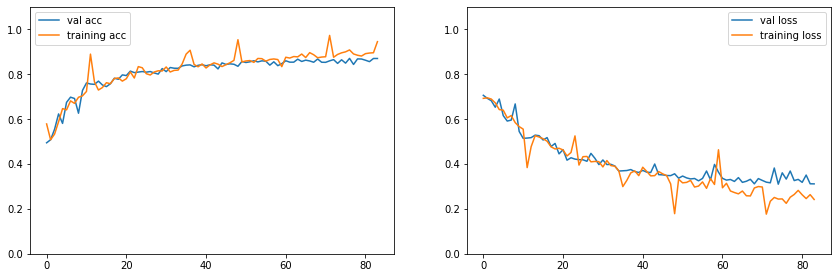

In [14]:
plot_checkpoints = (0, None)  # 'None' to plot to the end
plt.figure(figsize=(30, 10))
        
# accuracy
plt.subplot(2,4,1)
plt.ylim(0, 1.1)
plt.plot(range(len(validation_acc_lst[plot_checkpoints[0]:plot_checkpoints[1]])), validation_acc_lst[plot_checkpoints[0]:plot_checkpoints[1]])
plt.plot(range(len(training_acc_lst[plot_checkpoints[0]:plot_checkpoints[1]])), training_acc_lst[plot_checkpoints[0]:plot_checkpoints[1]])
plt.legend(['val acc', 'training acc'])

# loss
plt.subplot(2,4,2)
plt.ylim(0, 1.1)
plt.plot(range(len(validation_loss_lst[plot_checkpoints[0]:plot_checkpoints[1]])), validation_loss_lst[plot_checkpoints[0]:plot_checkpoints[1]])
plt.plot(range(len(training_loss_lst[plot_checkpoints[0]:plot_checkpoints[1]])), training_loss_lst[plot_checkpoints[0]:plot_checkpoints[1]])
plt.legend(['val loss', 'training loss'])

plt.show()

# Visualize validation results

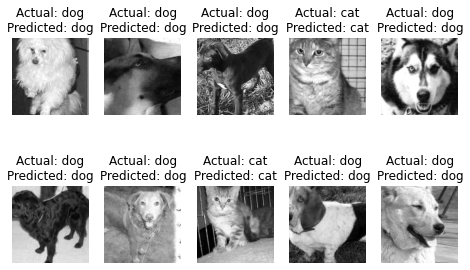

In [15]:
DRAW_IMGS = 10

# visualize validation results
fig = plt.figure(figsize=(8, 5))
fig.tight_layout()
show_imgs_idx = np.random.choice(len(validation_set), DRAW_IMGS, replace=False)
for i, (val_test_sample, val_test_label) in enumerate(data_utils.Subset(validation_set, show_imgs_idx)):
    plt.subplot(2, DRAW_IMGS // 2, i+1)
    plt.title(f'Actual: {lbl_code_to_class(val_test_label)}\nPredicted: {lbl_code_to_class(validation_predictions[show_imgs_idx[i]])}')
    plt.axis('off')
    plt.imshow(val_test_sample[0,::], cmap='gray')

# Testing

In [16]:
model.train(False)  # ensure we're in eval mode

test_predictions = []
test_idx = []
print('Testing...')
for X,id_ in test_loader:
    with torch.no_grad():
        X = X.to(device)
        predictions = model(X)

        test_idx.extend(id_.cpu().numpy())
        test_predictions.extend(F.softmax(predictions, dim=1)[:, 1].cpu().numpy())  # they want the probability that the sample is a dog:
                                                      # https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview/evaluation#:~:text=probability%20that%20image%20is%20a%20dog

submission = pd.DataFrame({'id': test_idx, 'label': test_predictions}).sort_values(by='id')
submission.to_csv(f'submission.csv', index=False)
print(f'Submission saved')

Testing...
Submission saved


In [17]:
if CLEAN_IMGS:
    from shutil import rmtree
    from os import path
    if path.exists(TRAINING_DIR):
        rmtree(TRAINING_DIR)
    if path.exists(TEST_DIR):
        rmtree(TEST_DIR)
    print('Images removed.')

Images removed.
